# Cross-Entropy Hill-Climbing with a 2-Layer Neural Network
Here we will train an agent with a 2-layer neural network to solve a continuous state and action task, [MountainCar](https://gym.openai.com/envs/MountainCarContinuous-v0/), using the [cross-entropy method](https://en.wikipedia.org/wiki/Cross-entropy_method). I've previously [implemented CEM](https://github.com/andrefmsmith/amsRL_openAIgym/blob/master/CodeBlog_Cartpole_Policy.ipynb) on a simpler task, Cartpole, solvable with a single-layer network.  

In CEM, when applied to policy networks in reinforcement learning, at every episode we generate a range of candidate policies (weights and biases) by adding noise, drawn from a gaussian distribution, to our current set of policy parameters. We then evaluate the candidate policies by collecting the return on the episode generated by each and averaging the parameters of the top performing policies. Optionally, we can use adaptive noise scaling to change the magnitude of our noise parameter (how much to scale the gaussian by) at each iteration, depending on whether compared to the previous iteration return was increased (*decrease* noise, exploring the neighbourhood with smaller steps) or decreased (*increase* noise, exploring a broader neighbourhood of parameters).

In [1]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import heapq

### Environment
```MountainCarContinuous-v0``` has **continual** observation and action spaces, the former being two-dimensional and the latter one-dimensional. The agent controls a car attempting to climb over a steep hill. However, its 'engine' isn't powerful enough to scale the mountain in a single pass:  
<img src="https://pythonawesome.com/content/images/2019/07/mountaincar.gif" width="400">  

Therefore, the agent has to gather enough momentum by driving back and forth, controlling acceleration appropriately in order to gather enough momentum to scale over the mountain. The action is a single continuous value between -1 and 1. We will use a neural network with one hidden layer to learn a policy to achieve this.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)
print('Training on {}.'.format(device))

observation space: Box(2,)
action space: Box(1,)
  - low: [-1.]
  - high: [1.]
Training on cuda:0.


c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Policy network Agent and its methods
We first define an Agent class inheriting properties from a pyTorch neural network class. First we configure the architecture of the **neural network** which will have our policy embedded:
```Python
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()```
The input layer size matches the dimensionality of our observation space and the output layer size that of the action space, with a hiden layer of size ```h_size``` in between:
```Python
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)```
  
We define a **forward propagation** method where we use ReLu on the hidden layer and tanh on the output, since we want output to vary continuously in [-1, 1]. 
```Python
    def forward(self,x ):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))#F.tanh(self.fc2(x))
        return x.cpu().data```

The **populate** method:
```Python
def populate(self, best_wb, noise):```
takes in an array of weights and biases ```best_wb```, which is expected to be structured as an array of lists whereby ```best_wb[0]``` corresponds to the weights of the hidden layer and ```best_wb[1]``` to the weights of the output layer. Indices 2 and 3 correspond to the respective layer's biases. If we wanted to use a different architecture, ```populate``` should be changed and its unpacking of weights and biases edited to respect this organisational scheme.  

For each set of parameters unpacked, ```populate``` adds to it an array of values of the same size, drawn from a gaussian distribution scaled by a noise parameter, then returns a new array of parameters organised in the same way as its input ```best_wb```.  

We then define a method for **assigning weights** to the right layers of our policy network.
```Python
def assign_weights(self, new_weights):```
We will need to call this method at each iteration in order to update our policy network's parameters. For each layer, we call the right index from the weights matrix and turn it into a torch float tensor then copy in-place onto the policy network's parameters.  

Finally, for convenience and tidiness we define an **evaluate** method:
```Python
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.assign_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):```
which begins by assigning to our policy network a new set of parameters, passing them to the network for forward propagation to compute which action to take and tally up the return generated by that action. This method returns the total episode return for a given set of input weights.

In [3]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
    
    def forward(self,x ):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data
        
    def populate(self, best_wb, noise):
        w_fc1 = best_wb[0] + noise*(np.random.randn(self.h_size, self.s_size))
        w_fc2 = best_wb[1] + noise*(np.random.randn(self.a_size, self.h_size))
        
        b_fc1 = best_wb[2] + noise*np.random.randn(self.h_size)
        b_fc2 = best_wb[3] + noise*np.random.randn(self.a_size)
        return np.array((w_fc1, w_fc2, b_fc1, b_fc2))
    
    def assign_weights(self, new_weights):
        self.fc1.weight.data.copy_(torch.from_numpy(new_weights[0].astype(float)))
        self.fc2.weight.data.copy_(torch.from_numpy(new_weights[1].astype(float)))
        self.fc1.bias.data.copy_(torch.from_numpy(new_weights[2].astype(float)))
        self.fc2.bias.data.copy_(torch.from_numpy(new_weights[3].astype(float)))
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.assign_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return

### Training
We can now define a training function, ```cem```. The best weight is initialised using ```agent.populate``` inputting a vector of zeros as the initial network, to which an appropriately-sized gaussian is added (noise=1). For each iteration, we draw up a list of candidate policies, each of them itself a list of numpy arrays, then compute the return for each policy and identify the ```topk``` policies. A new ```best_weight``` is computed by averaging parameters over these policies, its return is computed by forward propagation (using ```evaluate``` method) and added to the tally of scores. If the latest score represents an improvement over the previous one, we lower the noise parameter; else we increase it (adaptive noise scaling). 

In [4]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, topk=10, noise=0.5):
    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = agent.populate([0,0,0,0], noise=1)
    
    for i_iteration in range(1, n_iterations+1):
        weights_pop = [agent.populate(best_weight, noise) for i in range(pop_size)]
        returns = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        elite_idxs = returns.argsort()[-topk:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)
        
        return_ = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(return_)
        scores.append(return_)
        #if return_ >= scores[-1]:
        #    noise*=0.9
        #else:
        #    noise*=2
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

In [6]:
s_size = 2
h_size = 16
a_size = 1

In [7]:
agent=Agent(env).to(device)
scores = cem(pop_size=40, topk=8)

Episode 10	Average Score: -4.74
Episode 20	Average Score: -4.16
Episode 30	Average Score: 25.35
Episode 40	Average Score: 42.82
Episode 50	Average Score: 53.02
Episode 60	Average Score: 59.70
Episode 70	Average Score: 64.32
Episode 80	Average Score: 67.94
Episode 90	Average Score: 70.62
Episode 100	Average Score: 72.80
Episode 110	Average Score: 82.69

Environment solved in 18 iterations!	Average Score: 90.45


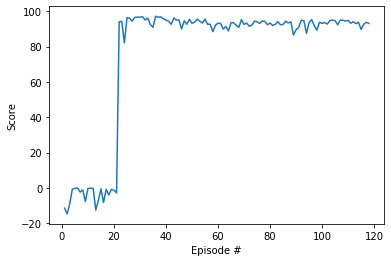

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()